---
# LG Smart Mirror Image Extraction
> - 물체가 녹화된 비디오에서 자동으로 이미지 추출
- 배경제거와 통계적 처리기법을 활용

In [1]:
import cv2
from matplotlib import pyplot as plt
import math
import numpy as np
import statistics
import subprocess
import os, shutil, platform
import pandas as pd
from glob import glob
from tqdm import tqdm_notebook as tqdm
from time import sleep
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter

class ImageExtractor:
    def __init__(self, rootPath, filename):
        self.data = []
        self.os = platform.system() # Windows, Linux
        self.cap = None
        self.errorArr = []
        self.rawDirPath = ""
        self.distArrFilitered_flat=[]  # 센터 거리값 규칙 통과한 것들 flat하게 저장
        self.imageWidth = 224 # 추출할 이미지 너비
        self.imageHeight = 224 # 추출할 이미지 높이 
        self.CONSTANT_RATIO = False # 추출할 이미지 리사이징할때 ratio warp할지
        self.n_cluster = 5 # 히스토그램 클러스터 개수
        self.SHOW_KMEANS_PLOT = False # kmeans plot 보여줄지
        self.candidateImages = []
        self.itemName = os.path.splitext(filename)[0]
        self.rootPath = rootPath
        self.videoPath = os.path.join(self.rootPath, "videos", filename)
        self.videoResizedPath = os.path.join(self.rootPath, "videos_resized", filename)
        self.videoResizedDirPath = os.path.join(self.rootPath, "videos_resized")
        self.imgDirPath = os.path.join(self.rootPath, "images", self.itemName)
        self.imgExtDirPath = os.path.join(self.rootPath, "images_ext", self.itemName)
        self.cam_model = None
        
        assert bool(self.itemName), "itemName should not be null value."

    # get video length for metadata crashed file
    def get_video_length(self, infilename):
        cnt=0
        self.cap = cv2.VideoCapture(infilename)
        while(True):
            ret, frame = self.cap.read()
            if ret:
                cnt+=1
            else: break
        self.videoLength = cnt
        self.cap.release()
        return cnt

    # 비디오 정보 가져오기(비디오용)
    def get_video_info(self, infilename):
        self.cap = cv2.VideoCapture(infilename)
        if not self.cap.isOpened():
            print("could not open :", infilename)
            exit(0)

        self.videoLength = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.videoWidth = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.videoHeight = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)
        self.adjCenter = [self.videoWidth/2, self.videoHeight/2] # 처음엔 중심부터 탐색
        self.cap.release()
        return

    # 비디오 리사이징(비디오용)
    def resizeVideo(self, mode="resize", crop_scsle_ratio=[0.2,0.2,0.6,0.6]):
        """
        @params mode: 'resize', 'crop'
        @params crop_scsle_ratio: [x,y,h,w] required only for 'crop' mode
        """
        # get original video meta infomation
        self.get_video_info(self.videoPath)

        # 리사이징된 비디오 파일 저장 패스
        if not os.path.isdir(self.videoResizedDirPath): os.makedirs(self.videoResizedDirPath)

        # make resized video
        if os.path.isfile(self.videoResizedPath):
            print('[Notice]:', self.videoResizedPath, 'aleady exist. remove it!')     
            os.remove(self.videoResizedPath)       

        # 비디오 스케일 종횡비 결정
        if mode=='crop':
            r_xx, r_yy, r_ww, r_hh = crop_scsle_ratio
            ww=int(self.videoWidth*r_ww)
            hh=int(self.videoHeight*r_hh)
            xx=int(self.videoWidth*r_xx)
            yy=int(self.videoHeight*r_yy)
            crop = "crop=%d:%d:%d:%d,fps=30"%(ww,hh,xx,yy) # w,h,x,y
            command = ['ffmpeg', '-i', self.videoPath, '-filter:v', crop, self.videoResizedPath]
        elif mode=='resize':
            # 'ffmpeg -i "video/190703/AGE20_S-essence cover tx.mp4" -vf scale=-1:960 video/resized/out.mp4'        
            if self.videoWidth>1000 or self.videoHeight>1000:
                w = int(self.videoWidth/2)
                h = int(self.videoHeight/2)
                # scale = "scale=-1:%d"%(h)
                scale = "scale=iw/2:-1"
                # scale = "scale=%d:%d"%(w,h) # 이거 하면 원본 oritation 정보 잃어버림
                command = ['ffmpeg', '-i', self.videoPath, '-vf', scale, self.videoResizedPath]
            else: # just copy and rename video file
                if self.os == 'Windows':
                    command = ['cmd', '\/c', 'copy', self.videoPath, self.videoResizedPath]
                elif self.os == 'Linuix':
                    command = ['cp', self.videoPath, self.videoResizedPath]

        print('[Command]: \n', command)
        # 커맨드 실행    
        try:
            cmd_res = subprocess.check_output(command)
            print(cmd_res)
            print('[self.videoResizedPath]:', self.videoResizedPath)
            self.get_video_info(self.videoResizedPath)
        except:
            print('***[Error occured]: ffmpeg', self.videoResizedPath)

        return

    # 카메라 중심에서의 거리계산 
    def calcDist(self, d):
#         cx = self.videoWidth/2
#         cy = self.videoHeight/2
        cx = self.adjCenter[0]
        cy = self.adjCenter[1]
        x=d[0]; y=d[1]; width=d[2]; height=d[3]
        x_c = x+width/2
        y_c = y+height/2
        dist = math.sqrt((cx-x_c)**2 + (cy-y_c)**2)
        return (d, dist)

    # 면적비를 이용해 유효한 사각영역 계산
    def mergeRect(self, rectArr, PreFrameArea, PreRect, ratio=.8):
        # dist threshold 기준 계산
        distArr = np.array([e[-1] for e in rectArr])
        distDiffArr = distArr[1:] - distArr[:-1]
        if len(rectArr)>2: threshold = statistics.median(distDiffArr)*10 # 10은 사후 검토값이므로 바뀔 수 있음
        else: threshold = math.inf

        finRec = (int(self.videoWidth/2), int(self.videoHeight/2) ,0,0)
        netArea = self.videoHeight*self.videoWidth
        prewidth = PreRect[2]-PreRect[0]
        preheight = PreRect[3]-PreRect[1]
        precalcArea = math.inf
        predist=math.inf
        self.distArrFilitered_flat.append(0)
        for rect in rectArr:
            rectOnly, dist = rect
            x = min(finRec[0], rectOnly[0])
            y = min(finRec[1], rectOnly[1])
            x2= max(finRec[2], rectOnly[0]+rectOnly[2])
            y2= max(finRec[3], rectOnly[1]+rectOnly[3])
            width = x2-x
            height = y2-y

            # 사각 영역 합치는 주요 규칙
            if self.calcArea([x, y, x2, y2])> netArea*ratio: break # 전체면적 비율 제한 (ratio 이상시 멈춤)
            if self.calcArea([x, y, x2, y2])> netArea*0.2: # 초반에 전체면적대비 20%까지는 아래 조건들 무시
                # if dist>predist*1.8: break
                if dist-predist>threshold: break # 센터 거리값으로 제한 - 우하단에 멀리있는거 머지하는것 방지. 너무 초기에는 작동안해야 함.
                if self.calcArea((x,y,x2,y2)) > precalcArea*1.8: break # 합치다가 갑자기 늘어나는 면적 비율 제한 (1.8배 이상시 멈춤)

            if self.calcArea([x, y, x2, y2])> PreFrameArea*1.8: break # 이전 프레임에서 그린 rect보다 갑자기 늘어나는 면적 비율 제한
            if width/prewidth>1.8 or height/preheight>1.8: break # 이전 프레임에서 그린 rect 보다 width, height 가 1.8배 늘어나는 것 제한
            self.distArrFilitered_flat.append(dist)
            finRec = (x,y,x2,y2)
            precalcArea = self.calcArea(finRec)
            predist = dist
            # print(self.calcArea(finRec), netArea*ratio)
        return finRec

    # 카메라 중점부터 사각영역 합치기
    def mergeByDist(self, data, PreFrameArea, PreRect, ratio=.8):    
        rects = [self.calcDist(d) for d in data]
        rects = sorted(rects, key=lambda x: x[-1]) # 중점 거리순으로 소팅
        # rects = np.array(rects)
        # pprint.pprint(rects)
        return self.mergeRect(rects, PreFrameArea, PreRect, ratio)

    # 사각형 면적 계산
    def calcArea(self, rect):
        return (rect[2]-rect[0])*(rect[3]-rect[1])

    # 검출영역 히스토그램 저장전 trim 및 ratio 후처리
    def trimImage(self, frame, detectedRect_orig):
        width, height = self.imageWidth, self.imageHeight
        ratio = height/width
        detectedRect= list(detectedRect_orig)

        detectedRect_width = detectedRect[2]-detectedRect[0]
        detectedRect_height = detectedRect[3]-detectedRect[1]
        
        # trim image
        img_trim = frame[detectedRect[1]:detectedRect[3], detectedRect[0]:detectedRect[2]] # y1, y2, x1, x2   
        # image resizing
        try:
            if self.CONSTANT_RATIO: img_trim = cv2.resize(img_trim, (width, height), interpolation=cv2.INTER_CUBIC)

            if(len(self.candidateImages)==0): self.candidateImages = np.stack([img_trim])
            else: self.candidateImages = np.concatenate([self.candidateImages, [img_trim]]) # 히스토그램 이상값 검출용 저장
        except: print('[Trim Error]:', img_trim.shape)
            
        return detectedRect

    def _fit_KMeans(self, data, k):
        model = KMeans(n_clusters=k, init="k-means++", max_iter=100, random_state=8).fit(data)
        centroids = model.cluster_centers_
        
        if(self.SHOW_KMEANS_PLOT):
            pca = PCA(n_components=2)
            transformed = pca.fit_transform(data)
            transformed_centroids = pca.transform(centroids)

            plt.figure(figsize=(8, 8))
            plt.scatter(transformed[:,0], transformed[:,1], marker='o', c=model.labels_)
            plt.scatter(transformed_centroids[:,0], transformed_centroids[:,1], marker='x', c='r')
            for i in range(len(data)): plt.annotate(i, (transformed[i,0], transformed[i,1]))
            for i in range(len(transformed_centroids)):
                plt.annotate(i, (transformed_centroids[i,0], transformed_centroids[i,1]))

            plt.grid(False)
            plt.title("PCA&K-Means: k={}, iteration={}, score={:5.2f}".format(k, k*10, model.score(data)))
            plt.show()
            
        return model

    def saveImage(self):
        #  image histogram 계산
        hists_r = list(map(lambda x: cv2.calcHist([x], [0], mask=None, histSize=[256], ranges=[0,256]), self.candidateImages))
        hists_g = list(map(lambda x: cv2.calcHist([x], [1], mask=None, histSize=[256], ranges=[0,256]), self.candidateImages))
        hists_b = list(map(lambda x: cv2.calcHist([x], [2], mask=None, histSize=[256], ranges=[0,256]), self.candidateImages))
        hists_r = np.array(hists_r).squeeze()
        hists_g = np.array(hists_g).squeeze()
        hists_b = np.array(hists_b).squeeze()    
        self.hists = np.concatenate([hists_r, hists_g, hists_b], axis=1) # n_imgs X 256*3
 
        if(len(self.hists)<self.n_cluster):
            print('[kmeans]: n_images -', len(self.hists), ', n_clusters -', self.n_cluster)
            print('[kmeans]: set k=', len(self.hists))
            kmeans = self._fit_KMeans(self.hists, len(self.hists))
        else: kmeans = self._fit_KMeans(self.hists, self.n_cluster)
        cluster_labels = Counter(kmeans.labels_) # 클러스터별 이미지 개수
        cluster_dists = []
        for i in range(len(kmeans.cluster_centers_)):
            dist = np.linalg.norm((kmeans.cluster_centers_[i]-kmeans.cluster_centers_), axis=1)
            dist = dist/math.sqrt(cluster_labels[i]) # 개수 많은 것은 주요 클러스터이므로 보정
            cluster_dists.append(dist)
        cluster_dists = np.array(cluster_dists)
        # 나머지 클러스터들과의 가까운 것(특이값 제외) 순으로 정렬
        # 최대 3개의 클러스터 사용
        major_cluster = cluster_dists.sum(axis=1).argsort()[:3]
        if(self.SHOW_KMEANS_PLOT): print('[major cluster]:', major_cluster)

        self.filtered_idx = [idx in major_cluster for idx in kmeans.labels_ ]

        imgDirOrig = self.imgExtDirPath
        if not os.path.isdir(imgDirOrig): os.makedirs(imgDirOrig)

        imgDirTemp = os.path.join(self.rootPath, "temp")
        if not os.path.isdir(imgDirTemp): os.makedirs(imgDirTemp)
    
        try:
            for idx, img_trim in enumerate(self.candidateImages[self.filtered_idx]):
                # mask image using CAM
                if(self.cam_model is not None):
                    image = img_trim[:,:,::-1].copy() # GBR to RGB
                    images_normal = self.cam_model.trans_normal(image).unsqueeze(0)
                    images_normal = images_normal.to(self.cam_model.device)
                    cams_scaled, masks_np = self.cam_model.getCAM(images_normal)
                    img_trim = img_trim*masks_np[0]

                imgPathOrig = os.path.join(imgDirOrig, str(self.itemName)+'_'+str(idx)+'.jpg')    
                imgPath = os.path.join(imgDirTemp, "temp"+'_'+str(idx)+'.jpg')
                cv2.imwrite(imgPath, img_trim) # 이미지 저장
                os.rename(imgPath, imgPathOrig) #  opencv 한글 패스 저장 안되므로 temp에 만들고 이름 수정 
                
                imgPathOrigFlip = os.path.join(imgDirOrig, str(self.itemName)+'_flip_'+str(idx)+'.jpg')    
                imgPathFlip = os.path.join(imgDirTemp, "temp"+'_flip_'+str(idx)+'.jpg')
                cv2.imwrite(imgPathFlip, np.array(img_trim)[:,::-1,:].copy()) # vertical flip 저장
                os.rename(imgPathFlip, imgPathOrigFlip) #  opencv 한글 패스 저장 안되므로 temp에 만들고 이름 수정 
        except Exception as ex:
            print('[Save Img Error:]', imgDirOrig, ex)

        shutil.rmtree(imgDirTemp)
        return
    
    def weight_array(self, ar, weights):
        zipped = zip(ar, weights)
        weighted = []
        for i in zipped:
            for j in range(i[1]):
                weighted.append(i[0])
        return np.array(weighted)    

    def preprocessVideo(self, merge_ratio_limit=0.7, SHOW_IMAGE = True):
        self.get_video_length(self.videoResizedPath)
        self.get_video_info(self.videoResizedPath)
        self.cap = cv2.VideoCapture(self.videoResizedPath)

        # 옵션 설명 http://layer0.authentise.com/segment-background-using-computer-vision.html
        fgbg = cv2.createBackgroundSubtractorMOG2(varThreshold=100, detectShadows=False)

        allData = [] # merged rect 저장하는 배열
        mergedAreas = [] # merged rect 넓이만저장하는 배열
        RectArea = self.videoHeight*self.videoWidth # initiation for put preframeArea to mergeRect 
        mergedRect= (0,0,self.videoWidth,self.videoHeight)
        self.candidateImages = []

        for i in tqdm(range(self.videoLength)):
            ret, frame = self.cap.read()
            if ret:
                fgmask = fgbg.apply(frame)     
                edge = cv2.Canny(fgmask, 0,200) # bgmask에 canny edge detection 적용
                nlabels, _labels, stats, centroids = cv2.connectedComponentsWithStats(edge)

                data = []
                for index, centroid in enumerate(centroids):
                    if stats[index][0] == 0 and stats[index][1] == 0:  #x,y
                        continue
                    if np.any(np.isnan(centroid)):
                        continue

                    x, y, width, height, area = stats[index]
                    centerX, centerY = int(centroid[0]), int(centroid[1])

                    if area > 20: #  컨벡스헐 크기
                        # 유효한 값만 저장
                        data.append(stats[index])

                        if(SHOW_IMAGE):
                            cv2.circle(frame, (centerX, centerY), 1, (0, 255, 0), 2)
                            cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 255, 0))

                data = np.array(data)
#                 self.data.append(data)
                if(len(data)>0):
#                     self.adjCenter = np.average(data[:,:2], axis=0, weights=data[:,-1])
                    self.adjCenter = np.median(self.weight_array(data[:,:2], data[:,-1]), axis=0) # area weighted median이용 해서 머지 시작점 계산

                # 머지된 사각형 그리기
                mergedRect = self.mergeByDist(data, RectArea, mergedRect, ratio=merge_ratio_limit)
                cv2.rectangle(frame, (mergedRect[0], mergedRect[1]), (mergedRect[2], mergedRect[3]), (0, 0, 255), 2)
                RectArea = self.calcArea(mergedRect)
                mergedAreas.append(RectArea)

                if(SHOW_IMAGE):
                    cv2.putText(frame, str(len(allData))+' RectArea '+str(RectArea), \
                                (30,self.videoHeight-30),cv2.FONT_HERSHEY_SIMPLEX, 1, (100,0,225), 3) # 프레임 id, 선별영역 넓이
                    cv2.circle(frame, (int(self.adjCenter[0]), int(self.adjCenter[1])), 1, (0,0,225), 6) # 중심점 렌더
                    cv2.putText(frame, str(len(data)), (30,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3) # 엣지 컨벡스헐 개수
                    # 영역 각각 그리기
                    cv2.imshow('bgsub', fgmask)
                    cv2.imshow('edge', edge)
                    cv2.imshow('frame',frame)


                k = cv2.waitKey(1) & 0xff 
                if k == 27: # esc
                    break

                allData.append(mergedRect)  
            else: break

        cv2.destroyAllWindows()    
        self.allData = allData
        self.mergedAreas = mergedAreas
        return

    def getStatistics(self, SHOW_PLOT=True):
        # -------------- 모든 유효한 dist 확인 -------------------
        if(SHOW_PLOT):
            print("distArrFilitered_flat_median:", statistics.median(self.distArrFilitered_flat))
            data_dist = np.array(self.distArrFilitered_flat[:1000])
            plt.figure(figsize=(18,9))
            plt.plot(data_dist[:], label="distArrFilitered_flat")
            plt.plot(data_dist[1:]-data_dist[:-1], label="distArrFilitered_flat diff")
            plt.legend(loc='upper right')
            plt.title("Dist per frame")
            plt.show()

        # --------------- 병합된 면적에서 + - 1.5 sigma 확인 (mean값 사용) -----------------------
        mergedAreas = np.array(self.mergedAreas)
        diff = abs(mergedAreas[1:] - mergedAreas[:-1])
        diff_median = statistics.median(diff)
        diff_mean = np.sum(diff)/len(diff)

        # 통계량 계산
        var= sum([math.pow(i, 2) for i in mergedAreas]) / len(mergedAreas) - math.pow(mergedAreas.mean(), 2)
        std = math.sqrt(var)
        upperBound = mergedAreas.mean()+ std*1.5
        lowerBound = mergedAreas.mean()- std

        # print("diff_median:", diff_median, ", diff_mean:", diff_mean)

        if(SHOW_PLOT):
            plt.figure(figsize=(18,9))
            plt.plot(mergedAreas, label="mergedArea")
            plt.plot(abs(mergedAreas[1:] - mergedAreas[:-1]), label="mergedArea diff")
            plt.axhline(upperBound, color='r')
            plt.axhline(lowerBound, color='r')
            plt.legend(loc='upper right')
            plt.title("Merged Rect Area")
            plt.show()

        # ------------------ 면적비 차분 통계량 (median값 사용) -------------------------
        mergedAreas = np.array(self.mergedAreas)
        diff_ratio = abs(mergedAreas[1:] - mergedAreas[:-1])/mergedAreas[1:]
        diff_ratio_median = statistics.median(diff_ratio)
        diff_ratio_mean = np.sum(diff_ratio)/len(diff_ratio)

        if(SHOW_PLOT):    
            print('diff_ratio_median:', diff_ratio_median, ', diff_ratio_mean:', diff_ratio_mean)
            plt.figure(figsize=(18,9))
            plt.plot(diff_ratio, label="abs area ratio")
            plt.axhline(diff_ratio_median*7, color='r')
            plt.axhline(diff_ratio_mean, color='g')
            plt.legend(loc='upper right')
            plt.title("Absolute area ratio")
            plt.show()

        # ------------------- 24프레임 단위로 윈도윙 보정 -----------------------
        meanArea24Frame=[]
        referenceAllData=[(0, i) for i in self.allData]

        if(len(mergedAreas)>=24):
            #0-23 frame mean
            sum_ = 0
            for i in range(0, 24):
                sum_ += mergedAreas[i]
                meanArea24Frame.append(sum_/(i+1))

            #24-end 24 frame mean
            for i in range(24,len(mergedAreas)):
                sum_ = 0
                for j in range(24):
                    sum_ += mergedAreas[i-j]
                meanArea24Frame.append(sum_/24)

            #check Area is much more bigger than mean (in this case twice)
            for i in range(len(mergedAreas)):
                # print(i, meanArea24Frame[i], mergedAreas[i])
                if(mergedAreas[i]/meanArea24Frame[i] > 2):
                    # print(i, 'data :',mergedAreas[i], 'mean :',meanArea24Frame[i])
                    j = 0
                    while(1):
                        j += 1
                        if(mergedAreas[i-j]/meanArea24Frame[i-j] < 2):
                            referenceAllData[i] = (1,self.allData[i-j])
                            # print(i, i-j, self.allData[i], self.allData[i-j],referenceAllData[i])
                            break

        self.statistics = {
          "upperBound":upperBound, 
          "lowerBound":lowerBound, 
          "diff_ratio_mean":diff_ratio_mean, 
          "diff_ratio_median":diff_ratio_median,
          "referenceAllData":referenceAllData
        }
        return

    def extractImages(self, interval=5, SHOW_IMAGE = True):
        print('[Extract Images]:', self.itemName)
        idx = 0
        shrink_ratio = 0.5 #  abnormal 관측시 5%씩 증감
        shrink_ratio_s = 0.5
        margin = 0.02 # 검출영역 마진
        cnt = 0 # 저장용 프레임 체크용
        preRect = []
        detectedRect= [0,0,0,0]

        # 추출될 이미지 저장 폴더 비우기... 비동기 버그 때문에 sleep넣음 
        if os.path.isdir(self.imgExtDirPath): shutil.rmtree(self.imgExtDirPath)
        sleep(0.1)
        os.makedirs(self.imgExtDirPath)

        self.cap = cv2.VideoCapture(self.videoResizedPath)
        for i in tqdm(range(self.videoLength)):
            ret, frame = self.cap.read()
            if ret:
                mergedRect = self.allData[idx]
                frame_for_save = frame.copy()
                if bool(preRect):
                    # 갑작스럽게 영역의 수축/팽창이 일어나는 경우
                    diff_area = self.calcArea(mergedRect)-self.calcArea(preRect)
                    # 이전 영역대비 수축/팽창 비율 에러 윈도윙 보정 적용, calcArea(preRect)는 0이 아니어야함
                    if self.statistics['referenceAllData'][idx][0] or (self.calcArea(preRect)!=0 and self.statistics['diff_ratio_median'] < abs(diff_area)/self.calcArea(preRect)):                        
                        if(self.statistics['referenceAllData'][idx][0]):
                            preRect = self.statistics['referenceAllData'][idx][1]

                        if diff_area>0: # 갑자기 커지는 경우
                            cv2.putText(frame, str(idx)+' abnormal dilation', (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)
                            # 이전 프레임보다 줄어들면 안됨... 어차피 팽창하는 경우라
                            x = max(preRect[0]*(1-shrink_ratio)+mergedRect[0]*shrink_ratio, 0)
                            y = max(preRect[1]*(1-shrink_ratio)+mergedRect[1]*shrink_ratio, 0)
                            x2 = min(preRect[2]*(1-shrink_ratio)+mergedRect[2]*shrink_ratio, self.videoWidth)
                            y2 = min(preRect[3]*(1-shrink_ratio)+mergedRect[3]*shrink_ratio, self.videoHeight) 
                            if (x2-x)>(mergedRect[2]-mergedRect[0]):
                                x = mergedRect[0]
                                x2 = mergedRect[2]
                            if (y2-y)>(mergedRect[3]-mergedRect[1]):
                                y = mergedRect[1]
                                y2 = mergedRect[3]

                        else: # 갑자기 작아지는 경우
                            cv2.putText(frame, str(idx)+' abnormal shrinkage', (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)        
                            x = preRect[0]*(1-shrink_ratio_s)+mergedRect[0]*shrink_ratio_s
                            y = preRect[1]*(1-shrink_ratio_s)+mergedRect[1]*shrink_ratio_s
                            x2 = preRect[2]*(1-shrink_ratio_s)+mergedRect[2]*shrink_ratio_s
                            y2 = preRect[3]*(1-shrink_ratio_s)+mergedRect[3]*shrink_ratio_s

                        mergedRect = (int(x), int(y), int(x2), int(y2))

                    # 마진 넣기
                    width = preRect[2]-preRect[0]
                    height = preRect[3]-preRect[1]
                    detectedRect = (int(max(mergedRect[0]-width*margin/2, 0)),
                                    int(max(mergedRect[1]-height*margin/2, 0)),
                                    int(min(mergedRect[2]+width*margin/2, self.videoWidth)),
                                    int(min(mergedRect[3]+height*margin/2, self.videoHeight)) )
                    if(self.calcArea(detectedRect) > self.statistics['upperBound']): cv2.putText(frame, 'UPPER BOUND', (detectedRect[0], detectedRect[1]+40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)        
                    elif(self.calcArea(detectedRect) < self.statistics['lowerBound']): cv2.putText(frame, 'LOWER BOUND', (detectedRect[0], detectedRect[1]+40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,225), 3)        
                    else: 
                        cnt+=1
                        # n번째마다 저장
                        if(cnt%interval==0): 
                            trimedRect = self.trimImage(frame_for_save, detectedRect)
                            cv2.putText(frame, 'Candidate image', (40, self.videoHeight), cv2.FONT_HERSHEY_SIMPLEX, 1, (225,0,0), 3)        
                            cv2.rectangle(frame, (trimedRect[0], trimedRect[1]), (trimedRect[2], trimedRect[3]), (255, 0, 0), 2)        

                if idx>0: # 첫 프레임 무시
                    preRect = mergedRect          

                if SHOW_IMAGE:
                    cv2.rectangle(frame, (mergedRect[0], mergedRect[1]), (mergedRect[2], mergedRect[3]), (0, 0, 255), 2)
                    cv2.rectangle(frame, (detectedRect[0], detectedRect[1]), (detectedRect[2], detectedRect[3]), (0, 255, 255), 2)
                    cv2.imshow('frame',frame)

                k = cv2.waitKey(1) & 0xff 
                if k == 27: # esc
                    break

            else: break
            idx += 1    

        if self.cap: self.cap.release()
        self.saveImage()
        cv2.destroyAllWindows()      
        return  

A Jupyter Widget


[Extract Images]: AHC-ONLY FOR MAN LOTION


A Jupyter Widget

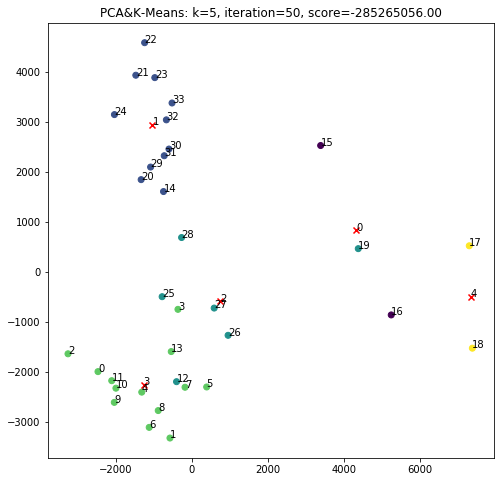

[major cluster]: [3 1 2]


In [3]:
# 비디오 ratio 결정
extractor.CONSTANT_RATIO = True
# 비디오 리사이즈
# extractor.resizeVideo(mode='crop') # mode: 'resize', 'crop'
# 비디오 전처리
extractor.preprocessVideo(merge_ratio_limit=.75, SHOW_IMAGE=True)
# 통계량 추출
extractor.getStatistics(SHOW_PLOT=False)
# 결과 이미지 영역 크롭
extractor.extractImages(interval=15, SHOW_IMAGE=True)

In [9]:
"""
폴더 전체 추출할때
비디오는 [rootPath]/videos 내에 있어야 한다
"""
rootPath = ".\\new-cosmetic-office"
for fileName in tqdm(os.listdir(os.path.join(rootPath, 'videos'))):
    print(os.path.splitext(fileName))
    extractor = ImageExtractor(rootPath, fileName)  
    # extractor.adjCenter = [extractor.videoWidth/2, extractor.videoHeight/2]
    # 비디오 ratio 결정
    extractor.CONSTANT_RATIO = True
    # 비디오 리사이즈
    extractor.resizeVideo()
    # 비디오 전처리
    extractor.preprocessVideo(merge_ratio_limit=0.75, SHOW_IMAGE=False)
    # 통계량 추출
    extractor.getStatistics(SHOW_PLOT=False)
    # 결과 이미지 영역 크롭
    extractor.extractImages(interval=15, SHOW_IMAGE=False)

A Jupyter Widget

('AHC-AGELESS REAL EYE CREAM FOR FACE', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\AHC-AGELESS REAL EYE CREAM FOR FACE.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\AHC-AGELESS REAL EYE CREAM FOR FACE.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\AHC-AGELESS REAL EYE CREAM FOR FACE.mp4


A Jupyter Widget

[Extract Images]: AHC-AGELESS REAL EYE CREAM FOR FACE


A Jupyter Widget

('AHC-Aura Secret Toneup Cream', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\AHC-Aura Secret Toneup Cream.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\AHC-Aura Secret Toneup Cream.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\AHC-Aura Secret Toneup Cream.mp4


A Jupyter Widget

[Extract Images]: AHC-Aura Secret Toneup Cream


A Jupyter Widget

('AHC-ONLY FOR MAN LOTION', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\AHC-ONLY FOR MAN LOTION.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\AHC-ONLY FOR MAN LOTION.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\AHC-ONLY FOR MAN LOTION.mp4


A Jupyter Widget

[Extract Images]: AHC-ONLY FOR MAN LOTION


A Jupyter Widget

('APIEU-데카소사이드 시카 겔 데이크림', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\APIEU-데카소사이드 시카 겔 데이크림.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\APIEU-데카소사이드 시카 겔 데이크림.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\APIEU-데카소사이드 시카 겔 데이크림.mp4


A Jupyter Widget

[Extract Images]: APIEU-데카소사이드 시카 겔 데이크림


A Jupyter Widget

('APIEU-스타트업 포어 프라이머', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\APIEU-스타트업 포어 프라이머.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\APIEU-스타트업 포어 프라이머.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\APIEU-스타트업 포어 프라이머.mp4


A Jupyter Widget

[Extract Images]: APIEU-스타트업 포어 프라이머


A Jupyter Widget

('BANILACO-프라임 프라이머 클래식', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\BANILACO-프라임 프라이머 클래식.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\BANILACO-프라임 프라이머 클래식.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\BANILACO-프라임 프라이머 클래식.mp4


A Jupyter Widget

[Extract Images]: BANILACO-프라임 프라이머 클래식


A Jupyter Widget

('BELIF-The true cream AQUA BOMB', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\BELIF-The true cream AQUA BOMB.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\BELIF-The true cream AQUA BOMB.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\BELIF-The true cream AQUA BOMB.mp4


A Jupyter Widget

[Extract Images]: BELIF-The true cream AQUA BOMB


A Jupyter Widget

('CLIO-스파클링 라인 프리즘 에어 아이섀도우', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\CLIO-스파클링 라인 프리즘 에어 아이섀도우.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\CLIO-스파클링 라인 프리즘 에어 아이섀도우.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\CLIO-스파클링 라인 프리즘 에어 아이섀도우.mp4


A Jupyter Widget

[Extract Images]: CLIO-스파클링 라인 프리즘 에어 아이섀도우


A Jupyter Widget

('FERRAGAMO-INCANTO CHARMS', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\FERRAGAMO-INCANTO CHARMS.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\FERRAGAMO-INCANTO CHARMS.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\FERRAGAMO-INCANTO CHARMS.mp4


A Jupyter Widget

[Extract Images]: FERRAGAMO-INCANTO CHARMS


A Jupyter Widget

('FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY.mp4


A Jupyter Widget

[Extract Images]: FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY


A Jupyter Widget

('FROMNATURE-에이지 인텐스 트리트먼트 에센스', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\FROMNATURE-에이지 인텐스 트리트먼트 에센스.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\FROMNATURE-에이지 인텐스 트리트먼트 에센스.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\FROMNATURE-에이지 인텐스 트리트먼트 에센스.mp4


A Jupyter Widget

[Extract Images]: FROMNATURE-에이지 인텐스 트리트먼트 에센스


A Jupyter Widget

('GENABELLE-LASOR SOOTHING SUNSCREEN', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\GENABELLE-LASOR SOOTHING SUNSCREEN.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\GENABELLE-LASOR SOOTHING SUNSCREEN.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\GENABELLE-LASOR SOOTHING SUNSCREEN.mp4


A Jupyter Widget

[Extract Images]: GENABELLE-LASOR SOOTHING SUNSCREEN


A Jupyter Widget

('GREEN FINGER-KIDS FACIAL LOTION', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\GREEN FINGER-KIDS FACIAL LOTION.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\GREEN FINGER-KIDS FACIAL LOTION.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\GREEN FINGER-KIDS FACIAL LOTION.mp4


A Jupyter Widget

[Extract Images]: GREEN FINGER-KIDS FACIAL LOTION


A Jupyter Widget

('HERA-BLACK CUSHION', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\HERA-BLACK CUSHION.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\HERA-BLACK CUSHION.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\HERA-BLACK CUSHION.mp4


A Jupyter Widget

[Extract Images]: HERA-BLACK CUSHION


A Jupyter Widget

('HOLIKA HOLIKA-GOOD CERA SUPER CERAMIDE MIST', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\HOLIKA HOLIKA-GOOD CERA SUPER CERAMIDE MIST.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\HOLIKA HOLIKA-GOOD CERA SUPER CERAMIDE MIST.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\HOLIKA HOLIKA-GOOD CERA SUPER CERAMIDE MIST.mp4


A Jupyter Widget

[Extract Images]: HOLIKA HOLIKA-GOOD CERA SUPER CERAMIDE MIST


A Jupyter Widget

('ILLIYOON-세라마이드 아토 수딩 젤', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\ILLIYOON-세라마이드 아토 수딩 젤.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\ILLIYOON-세라마이드 아토 수딩 젤.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\ILLIYOON-세라마이드 아토 수딩 젤.mp4


A Jupyter Widget

[Extract Images]: ILLIYOON-세라마이드 아토 수딩 젤


A Jupyter Widget

('INNISFREE-ALOE REVITAL SOOTHING GEL', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\INNISFREE-ALOE REVITAL SOOTHING GEL.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\INNISFREE-ALOE REVITAL SOOTHING GEL.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\INNISFREE-ALOE REVITAL SOOTHING GEL.mp4


A Jupyter Widget

[Extract Images]: INNISFREE-ALOE REVITAL SOOTHING GEL


A Jupyter Widget

('INNISFREE-GREEN TEA SEED ESSENC IN LOTION', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\INNISFREE-GREEN TEA SEED ESSENC IN LOTION.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\INNISFREE-GREEN TEA SEED ESSENC IN LOTION.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\INNISFREE-GREEN TEA SEED ESSENC IN LOTION.mp4


A Jupyter Widget

[Extract Images]: INNISFREE-GREEN TEA SEED ESSENC IN LOTION


A Jupyter Widget

('INNISFREE-JEJU CHERRY BLOSSOM SKIN', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\INNISFREE-JEJU CHERRY BLOSSOM SKIN.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\INNISFREE-JEJU CHERRY BLOSSOM SKIN.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\INNISFREE-JEJU CHERRY BLOSSOM SKIN.mp4


A Jupyter Widget

[Extract Images]: INNISFREE-JEJU CHERRY BLOSSOM SKIN


A Jupyter Widget

('INNISFREE-NO SEBUM Mineral Powder', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\INNISFREE-NO SEBUM Mineral Powder.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\INNISFREE-NO SEBUM Mineral Powder.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\INNISFREE-NO SEBUM Mineral Powder.mp4


A Jupyter Widget

[Extract Images]: INNISFREE-NO SEBUM Mineral Powder


A Jupyter Widget

('INNISFREE-마이 블러셔 햇살 가득 장미', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\INNISFREE-마이 블러셔 햇살 가득 장미.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\INNISFREE-마이 블러셔 햇살 가득 장미.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\INNISFREE-마이 블러셔 햇살 가득 장미.mp4


A Jupyter Widget

[Extract Images]: INNISFREE-마이 블러셔 햇살 가득 장미


A Jupyter Widget

('ISOI-인텐시브 에너자이징크림', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\ISOI-인텐시브 에너자이징크림.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\ISOI-인텐시브 에너자이징크림.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\ISOI-인텐시브 에너자이징크림.mp4


A Jupyter Widget

[Extract Images]: ISOI-인텐시브 에너자이징크림


A Jupyter Widget

('MACQUEEN-쥬얼포텐 아이글리터', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\MACQUEEN-쥬얼포텐 아이글리터.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\MACQUEEN-쥬얼포텐 아이글리터.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\MACQUEEN-쥬얼포텐 아이글리터.mp4


A Jupyter Widget

[Extract Images]: MACQUEEN-쥬얼포텐 아이글리터


A Jupyter Widget

('MISSHA-레이어 블러링 모공커버 프라이머', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\MISSHA-레이어 블러링 모공커버 프라이머.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\MISSHA-레이어 블러링 모공커버 프라이머.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\MISSHA-레이어 블러링 모공커버 프라이머.mp4


A Jupyter Widget

[Extract Images]: MISSHA-레이어 블러링 모공커버 프라이머


A Jupyter Widget

('NEUTROGENA-HAND CREAM', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\NEUTROGENA-HAND CREAM.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\NEUTROGENA-HAND CREAM.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\NEUTROGENA-HAND CREAM.mp4


A Jupyter Widget

[Extract Images]: NEUTROGENA-HAND CREAM


A Jupyter Widget

('PERIPERA-핑크의순간 컬렉션 잉크 컬러 마스카라', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\PERIPERA-핑크의순간 컬렉션 잉크 컬러 마스카라.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\PERIPERA-핑크의순간 컬렉션 잉크 컬러 마스카라.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\PERIPERA-핑크의순간 컬렉션 잉크 컬러 마스카라.mp4


A Jupyter Widget

[Extract Images]: PERIPERA-핑크의순간 컬렉션 잉크 컬러 마스카라


A Jupyter Widget

('RIRE-BUBLE BUBLE LIP MASK', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\RIRE-BUBLE BUBLE LIP MASK.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\RIRE-BUBLE BUBLE LIP MASK.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\RIRE-BUBLE BUBLE LIP MASK.mp4


A Jupyter Widget

[Extract Images]: RIRE-BUBLE BUBLE LIP MASK


A Jupyter Widget

('ROKKISS-카렌듈라 에멀젼', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\ROKKISS-카렌듈라 에멀젼.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\ROKKISS-카렌듈라 에멀젼.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\ROKKISS-카렌듈라 에멀젼.mp4


A Jupyter Widget

[Extract Images]: ROKKISS-카렌듈라 에멀젼


A Jupyter Widget

('SENKA-PERFECT WHIP', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\SENKA-PERFECT WHIP.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\SENKA-PERFECT WHIP.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\SENKA-PERFECT WHIP.mp4


A Jupyter Widget

[Extract Images]: SENKA-PERFECT WHIP


A Jupyter Widget

('TONYMOLY-피키비키 아트 팝 코렉팅 베이스', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\TONYMOLY-피키비키 아트 팝 코렉팅 베이스.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\TONYMOLY-피키비키 아트 팝 코렉팅 베이스.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\TONYMOLY-피키비키 아트 팝 코렉팅 베이스.mp4


A Jupyter Widget

[Extract Images]: TONYMOLY-피키비키 아트 팝 코렉팅 베이스


A Jupyter Widget

('VICHY-오 떼르말 미네랄 온천수 미스트', '.mp4')
[Command]: 
 ['ffmpeg', '-i', '.\\new-cosmetic-office\\videos\\VICHY-오 떼르말 미네랄 온천수 미스트.mp4', '-vf', 'scale=iw/2:-1', '.\\new-cosmetic-office\\videos_resized\\VICHY-오 떼르말 미네랄 온천수 미스트.mp4']
b''
[self.videoResizedPath]: .\new-cosmetic-office\videos_resized\VICHY-오 떼르말 미네랄 온천수 미스트.mp4


A Jupyter Widget

[Extract Images]: VICHY-오 떼르말 미네랄 온천수 미스트


A Jupyter Widget

In [6]:
extractor.cap.release()
cv2.destroyAllWindows()      

In [14]:
"""
비디오 처리없이 그냥 원본 프레임 샘플링
"""
rootPath = ".\\new-cosmetic-office"
for fileName in tqdm(os.listdir(os.path.join(rootPath, 'videos_resized'))):
    fn, ext =  os.path.splitext(fileName)
    imgExtDirPath = os.path.join(rootPath, "images_full", fn)
    print(fn)
    cap = cv2.VideoCapture(os.path.join(rootPath, 'videos_resized', fileName))
    idx = 0
    cnt = 0
    imgDirOrig = imgExtDirPath
    if not os.path.isdir(imgDirOrig): os.makedirs(imgDirOrig)            
    imgDirTemp = os.path.join(rootPath, "temp")
    if not os.path.isdir(imgDirTemp): os.makedirs(imgDirTemp)
    while(True):
        ret, frame = cap.read()
        if ret:            
            cnt += 1
            if(cnt%20==0):
                try:
                    imgPathOrig = os.path.join(imgDirOrig, str(fn)+'_'+str(idx)+'.jpg')    
                    imgPath = os.path.join(imgDirTemp, "temp"+'_'+str(idx)+'.jpg')
                    cv2.imwrite(imgPath, frame) # 이미지 저장
                    os.rename(imgPath, imgPathOrig) #  opencv 한글 패스 저장 안되므로 temp에 만들고 이름 수정 
                    idx+=1
                except:
                    print('[Save Img Error:]', imgPath)            
        else: break
    cap.release()
    shutil.rmtree(imgDirTemp)

A Jupyter Widget

AHC-AGELESS REAL EYE CREAM FOR FACE
AHC-Aura Secret Toneup Cream
AHC-ONLY FOR MAN LOTION
APIEU-데카소사이드 시카 겔 데이크림
APIEU-스타트업 포어 프라이머
BANILACO-프라임 프라이머 클래식
BELIF-The true cream AQUA BOMB
CLIO-스파클링 라인 프리즘 에어 아이섀도우
FERRAGAMO-INCANTO CHARMS
FERRARI-SCUDERIA BLACK EAU DE TOILETTE SPRAY
FROMNATURE-에이지 인텐스 트리트먼트 에센스
GENABELLE-LASOR SOOTHING SUNSCREEN
GREEN FINGER-KIDS FACIAL LOTION
HERA-BLACK CUSHION
HOLIKA HOLIKA-GOOD CERA SUPER CERAMIDE MIST
ILLIYOON-세라마이드 아토 수딩 젤
INNISFREE-ALOE REVITAL SOOTHING GEL
INNISFREE-GREEN TEA SEED ESSENC IN LOTION
INNISFREE-JEJU CHERRY BLOSSOM SKIN
INNISFREE-NO SEBUM Mineral Powder
INNISFREE-마이 블러셔 햇살 가득 장미
ISOI-인텐시브 에너자이징크림
MACQUEEN-쥬얼포텐 아이글리터
MISSHA-레이어 블러링 모공커버 프라이머
NEUTROGENA-HAND CREAM
PERIPERA-핑크의순간 컬렉션 잉크 컬러 마스카라
RIRE-BUBLE BUBLE LIP MASK
ROKKISS-카렌듈라 에멀젼
SENKA-PERFECT WHIP
TONYMOLY-피키비키 아트 팝 코렉팅 베이스
VICHY-오 떼르말 미네랄 온천수 미스트

